In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pylab as plt
import emcee
import math
from scipy.optimize import brentq

Impostiamo i parametri migliori per la leggibilità dei i nostri grafici.

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.figsize"] = (20, 10)

Implementiamo una funzione che ci aiuti a trovare il valore più appropriato per certe quantità rilevate da censimenti sporadici

In [3]:
def find_nearest(series,value):
  array = series.index[::-1]
  idx = np.searchsorted(array, value, side="right")
  if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
    label = array[idx-1]
  else:
    label = array[idx]
  return series.loc[label]

Carichiamo ed organizziamo i dati a nostra disposizione.

In [4]:
data = pd.read_csv("ILINet.csv", header=1, usecols = ["YEAR", "WEEK", "ILITOTAL", "NUM. OF PROVIDERS"], index_col=["YEAR", "WEEK"])

In [5]:
data = data.rename(columns={'ILITOTAL': 'NegDS'})
data = data.iloc[data.index <= (2016, 31)]
starting_year = data.index.get_level_values("YEAR")[0]
N_amb = find_nearest(pd.read_csv("US_outpatient_centers.csv", usecols=["YEAR", "NUM. OF PROVIDERS"], index_col=["YEAR"]).squeeze("columns"), starting_year)#40_600
N_pop_US = int(find_nearest(pd.read_csv("US_pop_by_year.csv", header = 1, usecols=["YEAR", "POPULATION (MLN)"], index_col=["YEAR"]).squeeze("columns"), starting_year)*1e6)# 320_640_000 #as of 2015, ignore newborns
NegDS = data["NegDS"] = np.rint(data["NegDS"] * N_amb/data["NUM. OF PROVIDERS"]).astype('int')
NegDS_0 = NegDS.iloc[0]

Implementiamo un generatore che, tramite il metodo di Eulero con passo di 1 settimana, integri la funzione associata al nostro $\Delta S$.

In [6]:
def neg_dsdt(S, N, beta, gamma):
    assert S > 0, "ERROR!\nS={}".format(S)
    negds = beta*S*(1 - S/N + gamma/beta*(np.log(S)- np.log(N)))
    return negds

class InvalidBoundsError (Exception):
    pass

def SIR(N, beta, gamma, NegDS_0=NegDS_0):
    a = np.nextafter(0, N)
    b = np.nextafter(N, 0)
    f = lambda S: neg_dsdt(S, N, beta, gamma) - NegDS_0
    i = 0
    while np.sign(f(a)) == np.sign(f(b)):
        a1, b1 = a, b - (b-a)/2
        if np.sign(f(a)) != np.sign(f(b)):
            a, b = a1, b1
            break
        else:
            a, b = a + (b-a)/2, b
        i += 1
        if i == 100:
            S = N
            break
    else:
        S = brentq(f, a, b)
    assert not np.isnan(S)
    ds = NegDS_0
    while True:
        S = S - ds
        if S <= 0 or np.isnan(S):
            raise InvalidBoundsError()
        yield S, ds
        ds = neg_dsdt(S, N, beta, gamma)

Implementiamo funzioni logaritmiche per le probabilità a priori dei parametri e per la _likelihood_ del modello da combinare nella funzione per la probabilità a posteriori. L'uso delle funzioni logaritmiche è necessario per far fronte ai bassi valori di probabilità incontrati nello spazio dei parametri. 

In [7]:
def logPriorG(gamma):
    return scipy.stats.gamma.logpdf(gamma, 1, scale=0.5)
def logPriorB(beta, gamma):
    return scipy.stats.gamma.logpdf(beta, 0.01*gamma, scale=0.5, loc=gamma)

def logLike(NegDS, TheoDS):
    if not np.all(TheoDS > 0):
        return -np.inf
    result = np.sum([scipy.stats.poisson.logpmf(negds, theods) for negds, theods in zip(NegDS, TheoDS)])
    assert not np.isnan(result)
    return result

def logPosterior(par, N, NegDS):
    beta, gamma = par
    if not (gamma > 0 and beta > gamma):
        return -np.inf
    sir = SIR(N, beta, gamma)
    try:
        TheoDS = np.array([next(sir)[1] for _ in range(len(NegDS))])
    except InvalidBoundsError:
        return -np.inf
    pl  = logLike(NegDS, TheoDS) 
    ppg = logPriorG(gamma) 
    ppb = logPriorB(beta, gamma)
    assert not np.isnan(pl)
    assert not np.isnan(ppg)
    assert not np.isnan(ppb)
    p = pl + ppg + ppb
    if np.isnan(p):
        assert False
    return p

Si noti che per alcuni parametri le funzioni logaritmiche di probabilità restituiscono il valore `-np.inf`. Ciò significha che i parametri, in queste regioni, modellizzano comportamenti del tutto incompatibili con il fenomeno osservato. Per avere un'idea di dove queste regioni di parametri incompatibili possano trovarsi esploriamo la funzione logaritmica di probabilità a posteriori con una griglia sullo spazio dei parametri per cui $\beta > \gamma$.

In [8]:
N = 25
g = np.array(np.tril_indices(int(6*N)))/N
f = np.array([logPosterior(x, N_pop_US, NegDS.to_numpy()) for x in g.T])
d = pd.Series(data=f, index=pd.MultiIndex.from_arrays(g))
d = d.unstack(1)

Disegnando una _heatmap_ associata a questa esplorazione troviamo, in bianco, le regioni dei parametri incompatibili, mentre le regioni che restituiscono valori di probabilità finiti sono presentate come colorate in base al loro valore.

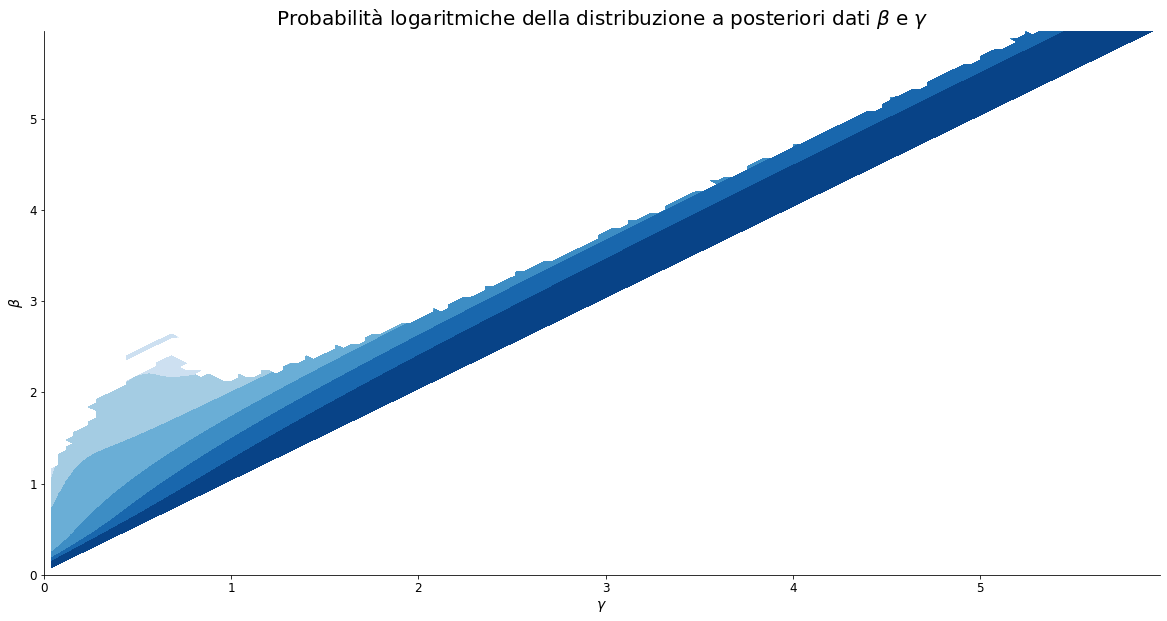

In [9]:
import seaborn as sns
from scipy import ndimage
fig, ax = plt.subplots(1,1)
# d.index.name=r"$\beta$"
# d.columns.name=r"$\gamma$"
with pd.option_context('mode.use_inf_as_na', True), sns.axes_style("dark"):
  #sns.heatmap(d, ax=ax, xticklabels=N, yticklabels=N, cmap="Blues", fmt="d")

  #ax.contour(np.unique(g[0]), np.unique(g[1]), d, levels=20, colors=["black"], linestyles="solid")
  ax.contourf(np.unique(g[0]), np.unique(g[1]), d, cmap="Blues")

ax.set_xlabel(r"$\gamma$")
ax.set_ylabel(r"$\beta$")

ax.set_title(r"Probabilità logaritmiche della distribuzione a posteriori dati $\beta$ e $\gamma$");
# ax.invert_yaxis()

Avendo osservato che nei pressi di $\beta \sim 1$ e $\gamma \sim 0.5$ abbiamo un'ampia regione con probabilità non nulla possiamo qui impostare i valori iniziali dei camminatori senza timore che rimangano "incastrati" nelle regioni a probabilità nulla.

In [10]:
pos = np.abs(np.random.randn(100,2)*0.1 + np.array([1.,0.5]))
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    
    nwalkers, ndim, logPosterior, args = (N_pop_US, NegDS.to_numpy())

)
sampler.run_mcmc(pos, 1_000);


In [11]:
samples = sampler.get_chain()

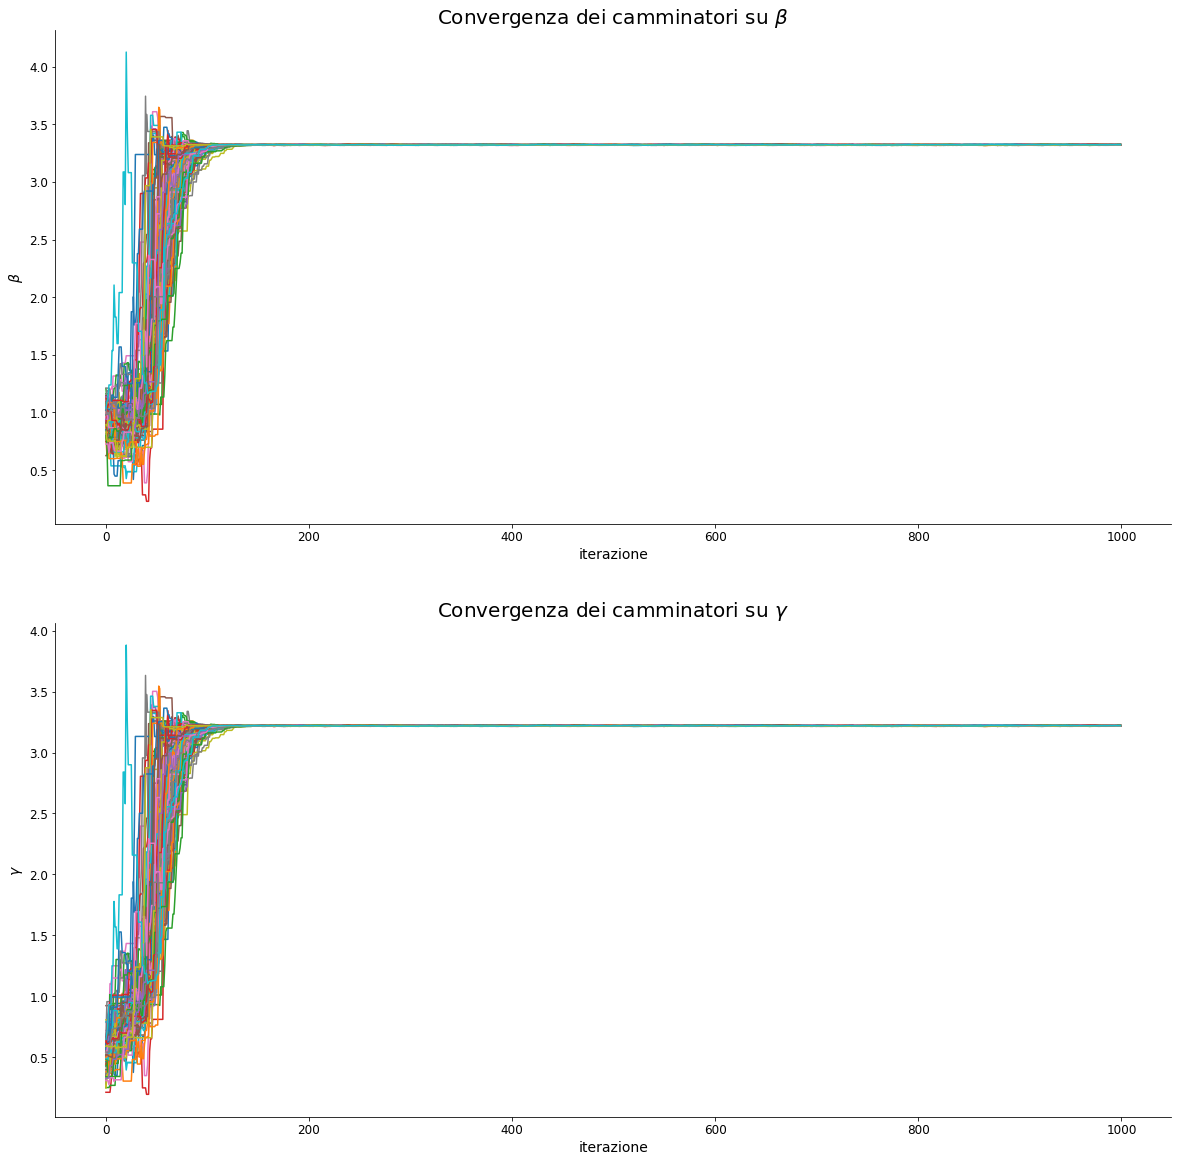

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,20))
ax1.plot(samples[:, :, 0])
ax1.set_xlabel(r"iterazione")
ax1.set_ylabel(r"$\beta$")
ax1.set_title(r"Convergenza dei camminatori su $\beta$");
ax2.plot(samples[:, :, 1])
ax2.set_xlabel(r"iterazione")
ax2.set_ylabel(r"$\gamma$")
ax2.set_title(r"Convergenza dei camminatori su $\gamma$");

Osserviamo che i camminatori convergono sia per i valori di $\beta$ che di $\gamma$. Valutiamo ora la loro distribuzione intorno a questo valore di convergenza.

In [13]:
goodsamples = sampler.get_chain(discard = 200, flat = True)
R_0s = np.divide(*(goodsamples.T))
goodsamples = np.concatenate((goodsamples,R_0s.reshape(-1, 1)), axis=1)
betaM, gammaM, R_0M = goodsamples.mean(axis=0)

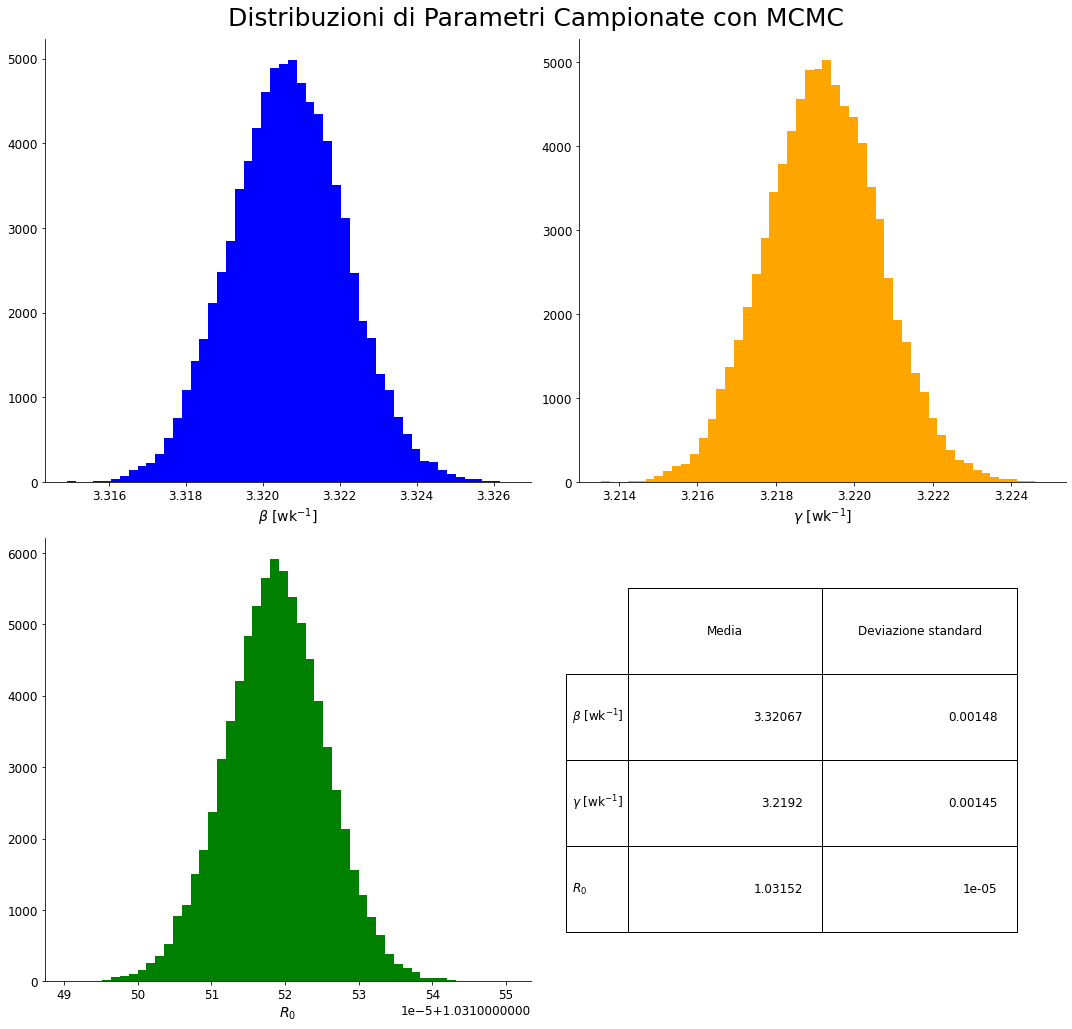

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
labels = [r"$\beta$ [wk$^{-1}$]",r"$\gamma$ [wk$^{-1}]$",r"$R_0$"]
ax1.hist(goodsamples[:, 0], bins = 50, color="blue")
ax1.set_xlabel(labels[0])
ax2.hist(goodsamples[:, 1], bins = 50, color="orange")
ax2.set_xlabel(labels[1])
ax3.hist(goodsamples[:, 2], bins = 50, color="green")
ax3.set_xlabel(labels[2])
ax4.axis('off')
ax4.axis('tight')
table = ax4.table(np.concatenate((goodsamples.mean(axis=0).reshape(-1,1), goodsamples.std(axis=0).reshape(-1,1)), axis=1).round(decimals=5),
  rowLabels=labels, colLabels=["Media", "Deviazione standard"], loc="center")
table.set_fontsize(14)
table.scale(0.8,6)
fig.tight_layout(rect=(0,0,1,0.93))
plt.suptitle("Distribuzioni di Parametri Campionate con MCMC", size = 25, y=0.95);

Troviamo delle distribuzioni la cui forma è compatibile con quella di una distribuzione Gamma, che è quella che ci aspettiamo dalla teoria, essendo le distribuzioni a priori dei parametri delle distribuzioni Gamma, le quali sono i _prior_ coniugati della distribuzione di Poisson che usiamo come _likelihood_. Osserviamo inoltre che i valori del parametro $\gamma$ riportati sono sensati, se confrontati con le osservazioni empiriche sui tempi di guarigione.

Disegnamo ora gli andamenti di $s$ e di $\Delta s$, dove $s$ è la frazione di popolazione suscettibile, sia rispetto ai dati a nostra disposizione che rispetto al modello che abbiamo inferito.

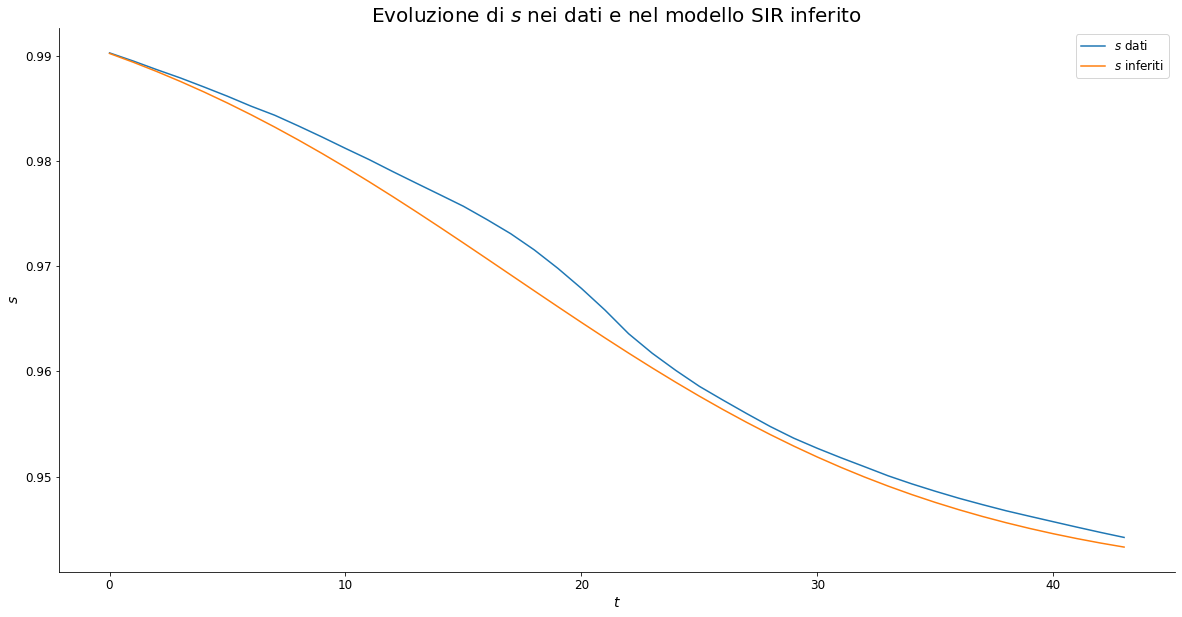

In [15]:
sir = SIR(N_pop_US, betaM, gammaM)
S_0, _ = next(sir)
s = (S_0 - np.cumsum(NegDS))/N_pop_US
plt.plot(s.to_numpy(), label = r"$s$ dati")
plt.plot(np.array([next(sir)[0] for _ in range(len(data.index))])/N_pop_US, label = r"$s$ inferiti")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$s$")
plt.title(r"Evoluzione di $s$ nei dati e nel modello SIR inferito");

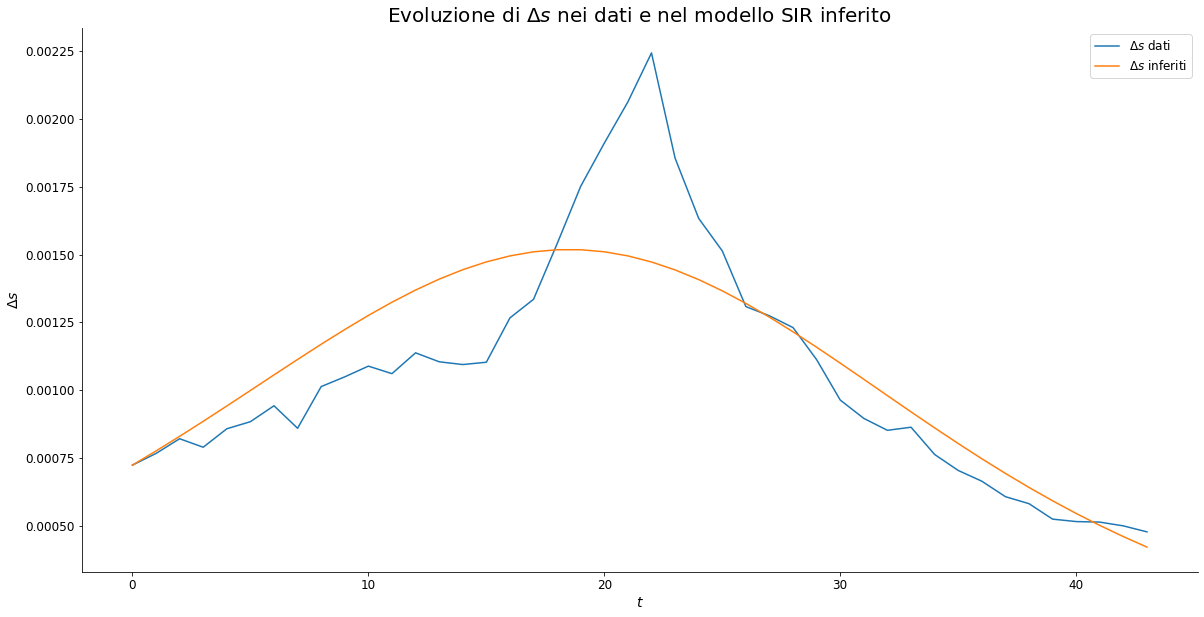

In [16]:
sir = SIR(N_pop_US, betaM, gammaM)
ds = NegDS/N_pop_US
plt.plot(ds.to_numpy(), label = r"$\Delta s$ dati")
plt.plot(np.array([next(sir)[1] for _ in range(len(data.index))])/N_pop_US, label = r"$\Delta s$ inferiti")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$\Delta s$")
plt.title(r"Evoluzione di $\Delta s$ nei dati e nel modello SIR inferito");

Osserviamo che il comportamento dei dati diverge anche significativamente dalla forma presa dalla previsione del nostro modello, in quanto il modello SIR riesce a rappresentare solo crudemente le complessità di un fenomeno epidemico, ma per i fini della nostra ricerca questa prima approssimazione risulta sufficiente.